Another popular strategy is using technical analysis, which involves using a combination of specific technical indicators such as the RSI (relative strength index), MACD (moving average convergance/divergance) and BOLL (Bollinger bands).  

Generally, the RSI is showing the "strength" of an asset. The higher the gain compared to the loss, the bigger the RSI. Thus, when it is too high, the asset is overvalued and when it is too low, the asset is undervalued. Usually if RSI > 70, the asset is overvalued and if RSI < 30, the asset is undervalued.  

The BOLL are two bands two standard deviations away from the 20 day moving average. When the price is above the higher band, the asset is considered to be overvalued. Likewise, when the price is below the lower band, the price is considered to be undervalued.  

MACD shows how the short term 12 day EMA (exponential moving average) is different from the 26 EMA (longer trend). Then it is compared to a 9 day MACD moving average signal line. If MACD is higher than the signal line, there is an upward price trend. Likewise, if MACD is lower than the signal line, there is a downward price trend.

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [180]:
class Long_Only_Backtester():
    ''' Class for the vectorized backtesting of simple Long-Short trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum).
         
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.Close.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "Long_Short_Backtester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["Date"], index_col = "Date")
        raw = raw.loc[self.start:self.end].copy()
        raw["returns"] = np.log(raw.Close / raw.Close.shift(1))
        
        raw["RSI"] = self.calculate_rsi(raw)
        
        raw["ema_12"] = raw["Close"].ewm(span=12, adjust=False, min_periods=12).mean()
        raw["ema_26"] = raw["Close"].ewm(span=26, adjust=False, min_periods=26).mean()
        raw["macd"] = raw["ema_12"] - raw["ema_26"]
        
        self.data = raw
        
    def test_strategy(self, arguments):
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        arguments: tuple (RSI_threshold_high, MACD_signal, BOLL_std_coeff)
        
        '''
        
        self.RSI_high = arguments[0]
        self.MACD = arguments[1]
        self.BOLL = arguments[2]
        
        
        self.prepare_data(arguments = arguments)
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, arguments):
        ''' Prepares the Data for Backtesting.
        
        arguments: tuple (RSI_threshold_high, MACD_signal, BOLL_std_coeff)
        
        '''
        ########################## Strategy-Specific #############################
        
        data = self.data[["Close", "returns", "RSI", "macd"]].copy()
        data["MACD_Hist"] = self.calculate_macd(data, signal_span=arguments[1])
        data["BOLL_UP"], data["BOLL_DOWN"] = self.calculate_boll(data, std_coeff=arguments[2])
        
        data.dropna(inplace = True)

        cond2 = ((data.RSI > arguments[0]) & (data.Close > data.BOLL_UP)) | \
                ((data.RSI > arguments[0]) & (data.MACD_Hist < 0)) | \
                ((data.MACD_Hist < 0) & (data.Close > data.BOLL_UP))
        
        data["position"] = 1
        data.loc[cond2, "position"] = 0

        ##########################################################################
        
        self.results = data
    
    @staticmethod
    def calculate_rsi(data, window_length=14):
        '''Calculates the relative strength index
        
        Parameters
        ============
        data: pd DataFrame
        
        window_length: int
            The length of moving averages to calculate RSI.
        '''
        temp = data[["Close", "returns"]].copy()
        
        # Calculate price differences
        temp["diff"] = temp["Close"].diff(1)
        temp["gain"] = temp["diff"].clip(lower=0).round(2)
        temp["loss"] = temp["diff"].clip(upper=0).abs().round(2)
        
        temp["avg_gain"] = temp["gain"].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
        temp["avg_loss"] = temp["loss"].rolling(window=window_length, min_periods=window_length).mean()[:window_length+1]
        
        #Calculate average gains and losses
        # Get smoothing averages (AVG_GAIN(16) = AVG_GAIN(15) * 13 + GAIN(16))
        # Average Gains
        for i, row in enumerate(temp["avg_gain"].iloc[window_length+1:]):
            temp["avg_gain"].iloc[i + window_length + 1] =\
                (temp["avg_gain"].iloc[i + window_length] *
                 (window_length - 1) +
                 temp["gain"].iloc[i + window_length + 1])\
                / window_length
        # Average Losses
        for i, row in enumerate(temp["avg_loss"].iloc[window_length+1:]):
            temp["avg_loss"].iloc[i + window_length + 1] =\
                (temp["avg_loss"].iloc[i + window_length] *
                 (window_length - 1) +
                 temp["loss"].iloc[i + window_length + 1])\
                / window_length
        
        # Calculate RSI
        temp["rs"] = temp["avg_gain"] / temp["avg_loss"]
        temp["rsi"] = 100 - (100 / (1.0 + temp["rs"]))
        
        return temp["rsi"]
    
    @staticmethod
    def calculate_macd(data, signal_span=9):
        '''Calculates moving average convergence/divergence
        
        Parameters
        ============
        data: pd DataFrame
        
        span: tuple (short period span, long period span, signal line span)
        '''
        temp = data[["Close", "macd"]].copy()
        
        temp["signal_line"] = temp["macd"].ewm(span=signal_span, adjust=False, min_periods=signal_span).mean()
        temp["macd_hist"] = temp["macd"] - temp["signal_line"]
        
        return temp["macd_hist"]
    
    @staticmethod
    def calculate_boll(data, ma_length=20, std_coeff=2):
        '''Calculates bollinger bands
        
        Parameters
        ============
        data: pd DataFrame
        
        ma_length: int
                The length for calculating the moving average
        
        std_coeff: int
                How many standard deviations away the bollinger bands will be
        '''
        temp = data[["Close", "returns"]].copy()
        sma = temp["Close"].rolling(window=ma_length).mean()
        std = temp["Close"].rolling(window=ma_length).std()
        temp["bollinger_up"] = sma + std * std_coeff
        temp["bollinger_down"] = sma - std * std_coeff
        
        return temp["bollinger_up"], temp["bollinger_down"]
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data["trades"] = data.position.diff().fillna(0).abs()
        data.strategy = data.strategy + data.trades * self.tc
        
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | TC = {}".format(self.symbol, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            plt.legend(["Buy and Hold multiple", "Strategy multiple"])
            
    def optimize_strategy(self, RSI_threshold_high, MACD_signal, 
                          BOLL_std_coeff, metric = "Multiple"):
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        RSI_threshold_high: tuple
            tuples of the form (start, end, step size).
        
        MACD_signal: tuple
            tuples of the form (start, end, step size).
            
        BOLL_std_coeff: list
            lists of all std coefficients to consider
        
        metric: str
            performance metric to be optimized (can be "Multiple" or "Sharpe")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        
        RSI_high_range = range(*RSI_threshold_high)
        MACD_signal_range = range(*MACD_signal)
        BOLL_std_range = BOLL_std_coeff
        
        combinations = list(product(RSI_high_range, MACD_signal_range, BOLL_std_range))
         
        performance = []
        for comb in combinations:
            self.prepare_data(arguments = (comb[0], comb[1], comb[2]))
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), 
                                              columns = ["RSI_high", "MACD_signal", "BOLL_std_coeff"])
        self.results_overview["performance"] = performance
        self.find_best_strategy()
        
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum).
        '''
        
        best = self.results_overview.nlargest(1, "performance")
        RSI_high = best.RSI_high.iloc[0]
        MACD_signal = best.MACD_signal.iloc[0]
        BOLL_std_coeff = best.BOLL_std_coeff.iloc[0]
        
        perf = best.performance.iloc[0]
        print("RSI_high: {} | MACD: {} | BOLL : {} | {}: {}".format(RSI_high, MACD_signal, BOLL_std_coeff, self.metric, round(perf, 5)))  
        self.test_strategy(arguments = (RSI_high, MACD_signal, BOLL_std_coeff))
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
       
        print(100 * "=")
        print("BOLL RSI MACD STRATEGY | INSTRUMENT = {} | PARAMETERS = {}".format(self.symbol, [self.RSI_high, self.MACD, self.BOLL]))
        print(100 * "-")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return self.calculate_cagr(series) / self.calculate_annualized_std(series)

Firstly, let's try 70% as the RSI high treshold, 9 days as the length for the MACD signal line and 2 deviations away from the moving average in BOLL, as these numbers are most common

In [181]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2017-08-17"
end = "2020-11-25"
tc = -0.00075
RSI_high = 70
MACD = 9
BOLL = 2

In [182]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol,
                              start = start, end = end, tc = tc)
tester.test_strategy(arguments = (RSI_high, MACD, BOLL))

BOLL RSI MACD STRATEGY | INSTRUMENT = BTCUSDT | PARAMETERS = [70, 9, 2]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         3.29456
Multiple (Buy-and-Hold):     4.639173
--------------------------------------
Out-/Underperformance:       -1.344613


CAGR:                        0.454182
Annualized Mean:             0.374756
Annualized Std:              0.785941
Sharpe Ratio:                0.577883


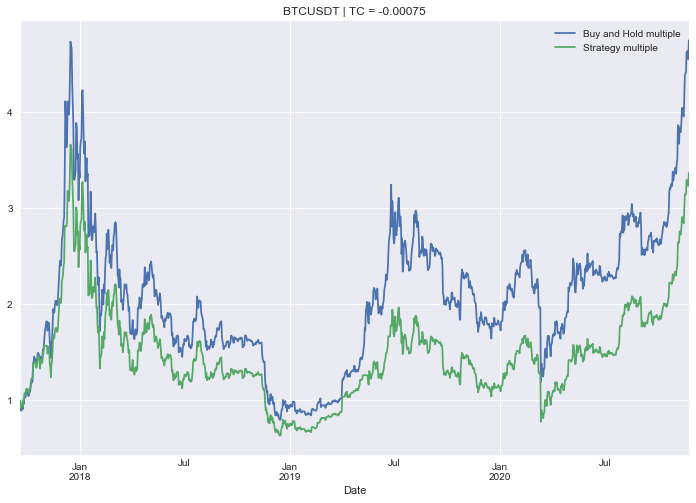

In [183]:
tester.plot_results()

Unfortunately, this strategy underperformed. However, let's try to optimize it. Maybe we will get better results after optimization

## Optimization

In [184]:
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [185]:
tester.optimize_strategy(RSI_threshold_high = (50, 90, 4),
                         MACD_signal = (5, 17, 2),
                         BOLL_std_coeff=[1, 1.3, 1.6, 1.9, 2.2, 2.5])

RSI_high: 82.0 | MACD: 11.0 | BOLL : 2.5 | Multiple: 5.31064
BOLL RSI MACD STRATEGY | INSTRUMENT = BTCUSDT | PARAMETERS = [82.0, 11.0, 2.5]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.310635
Multiple (Buy-and-Hold):     4.799772
--------------------------------------
Out-/Underperformance:       0.510863


CAGR:                        0.69095
Annualized Mean:             0.52573
Annualized Std:              0.81369
Sharpe Ratio:                0.849156


Now the results are better and our strategy is better than the simple buy and hold in the backward test

### Now let's take a look how each of the steps in our parameters effected the bot performance

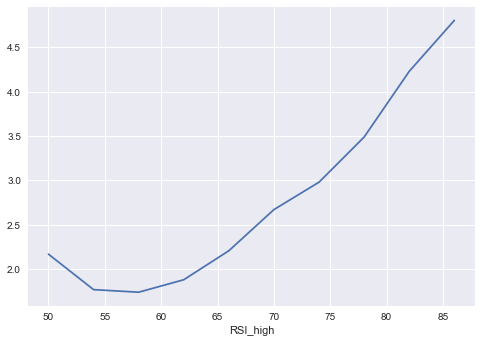

In [186]:
results = tester.results_overview
results.groupby("RSI_high").performance.mean().plot()
plt.show()

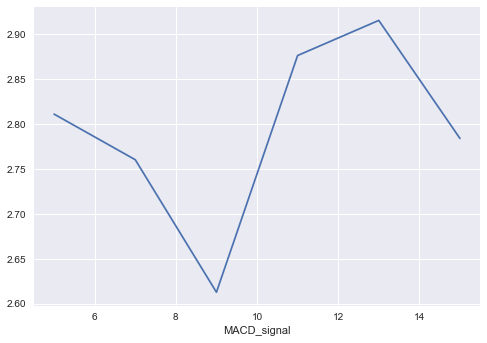

In [187]:
results = tester.results_overview
results.groupby("MACD_signal").performance.mean().plot()
plt.show()

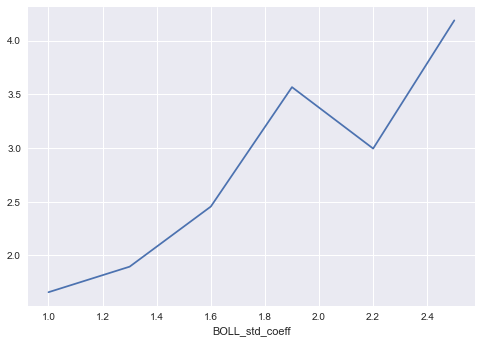

In [188]:
results = tester.results_overview
results.groupby("BOLL_std_coeff").performance.mean().plot()
plt.show()

As we see from the plots, it is best to take a 86% RSI threshold, a 12 day MACD signal line and 2.5 deviations away from the moving average for the Bollinger bands. However, an 86% RSI threshold is too high, we will almost never take a neutral position with such a threshold. Thus, let's try to use an 82% RSI threshold

In [189]:
tester.test_strategy((82, 12, 2.5))

BOLL RSI MACD STRATEGY | INSTRUMENT = BTCUSDT | PARAMETERS = [82, 12, 2.5]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         5.331489
Multiple (Buy-and-Hold):     5.185363
--------------------------------------
Out-/Underperformance:       0.146126


CAGR:                        0.693805
Annualized Mean:             0.527418
Annualized Std:              0.814035
Sharpe Ratio:                0.852303


In [190]:
tester.results.position.value_counts()

1    1154
0       7
Name: position, dtype: int64

## Forward testing

It is impossible to calculate MACD indicator until 26 days have passed. Thus, we will take the period from 2020-11-01 instead of 2020-11-26

In [191]:
filepath = "bitcoin.csv"
symbol = "BTCUSDT"
start = "2020-11-01"
end = "2021-12-31"
tc = -0.00075

In [192]:
RSI_high = 82
MACD = 12
BOLL = 2.5

In [193]:
tester = Long_Only_Backtester(filepath = filepath, symbol = symbol, start = start, end = end, tc = tc)
tester.test_strategy(arguments = (RSI_high, MACD, BOLL))

BOLL RSI MACD STRATEGY | INSTRUMENT = BTCUSDT | PARAMETERS = [82, 12, 2.5]
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         2.428468
Multiple (Buy-and-Hold):     2.387312
--------------------------------------
Out-/Underperformance:       0.041156


CAGR:                        1.300415
Annualized Mean:             0.83505
Annualized Std:              0.804242
Sharpe Ratio:                1.616946


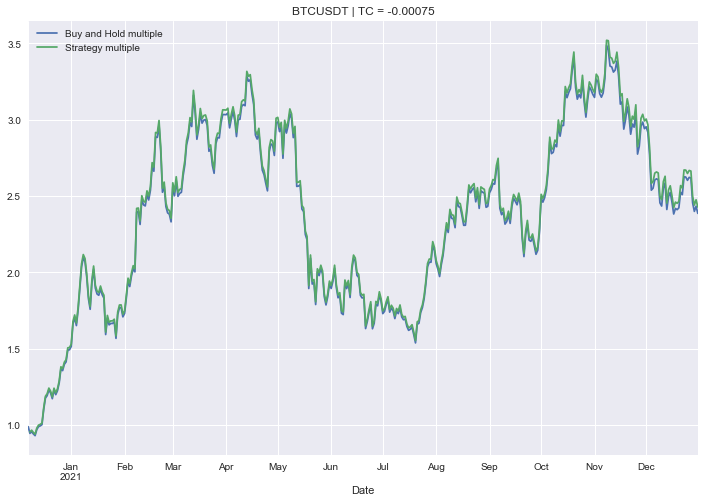

In [194]:
tester.plot_results()

As we see the multiple of this strategy is higher then the simple buy and hold but only slightly. Therefore, this strategy is somewhat valuable

## Price distribution

In [195]:
tester.results.position.value_counts()

1    389
0      1
Name: position, dtype: int64

As we see, we took a neutral position only once. Thus, this strategy is only slightly different from the buy and hold strategy. However, in that 1 situation when we took a short position, the prices did fall indeed, so it was a good choice to choose a neutral position.